In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

import semd2d_utils

In [2]:
events = np.loadtxt("../data_processed/events_refact.txt")
# this data is already filtered by time, no need to redo it here

In [3]:
# use only the specified patch of input events
patch_center = (90, 120)
patch_size = 180
events = semd2d_utils.filter_patch(events, patch_center, patch_size)

data_steps = 50 # timesteps to divide the data into
sim_steps = 50 # simulation steps
shape = (patch_size, patch_size)
t_start = events[0, 0]
duration = events[-1, 0] - events[0, 0]

In [4]:
args = {
    "shape":shape,
    "conv_shape": (3, 3),
    "conv_stride": (3, 3),
    "thresh_conv": 0.6,
    "detector_du": 0.1
}
data, data_u = semd2d_utils.run_sim(args, events, data_steps, sim_steps)

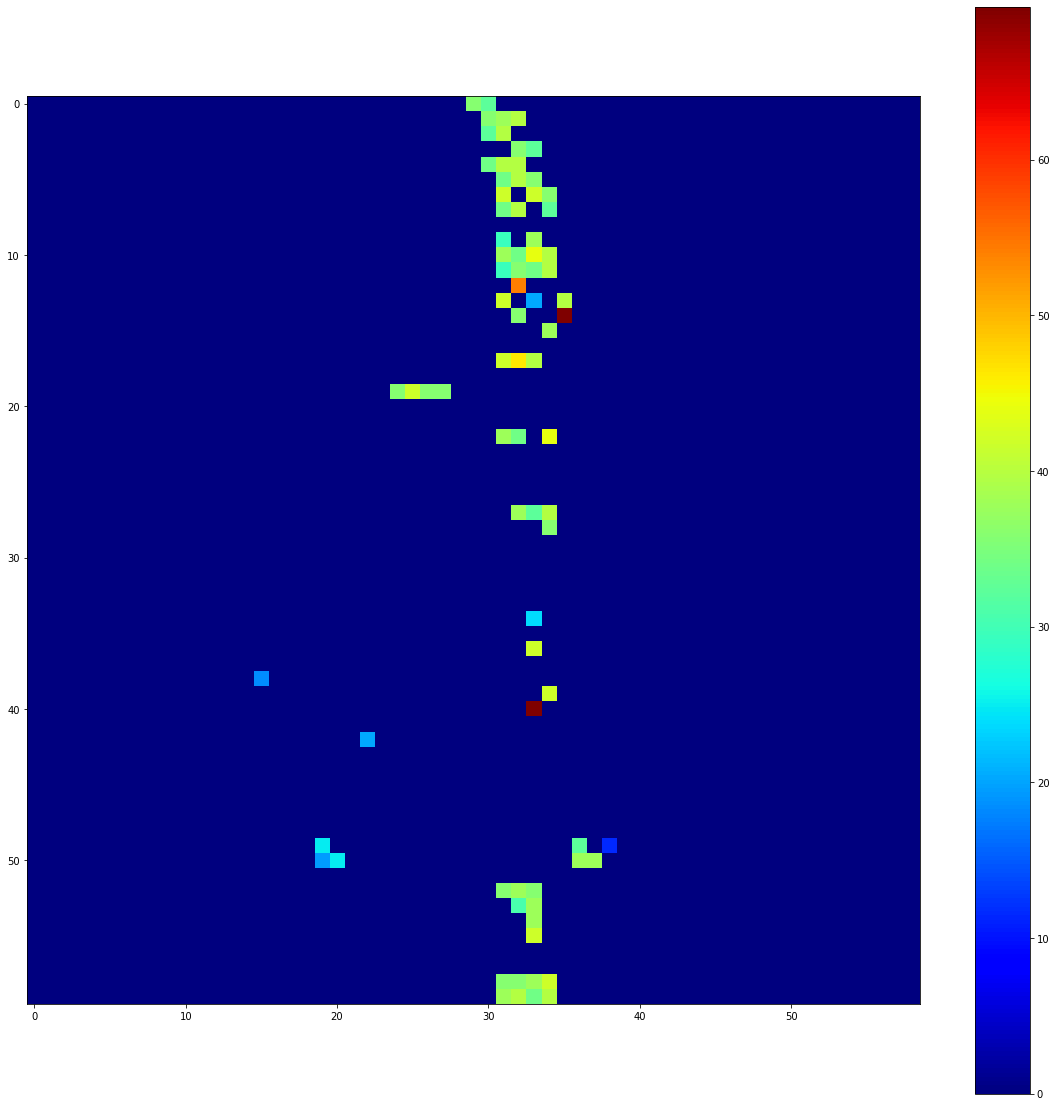

In [5]:
%matplotlib inline
plt.figure(figsize=(20, 20))
m = plt.imshow(np.delete(np.sum(data, axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

In [6]:
d = data_u["Process_0"]["u"]

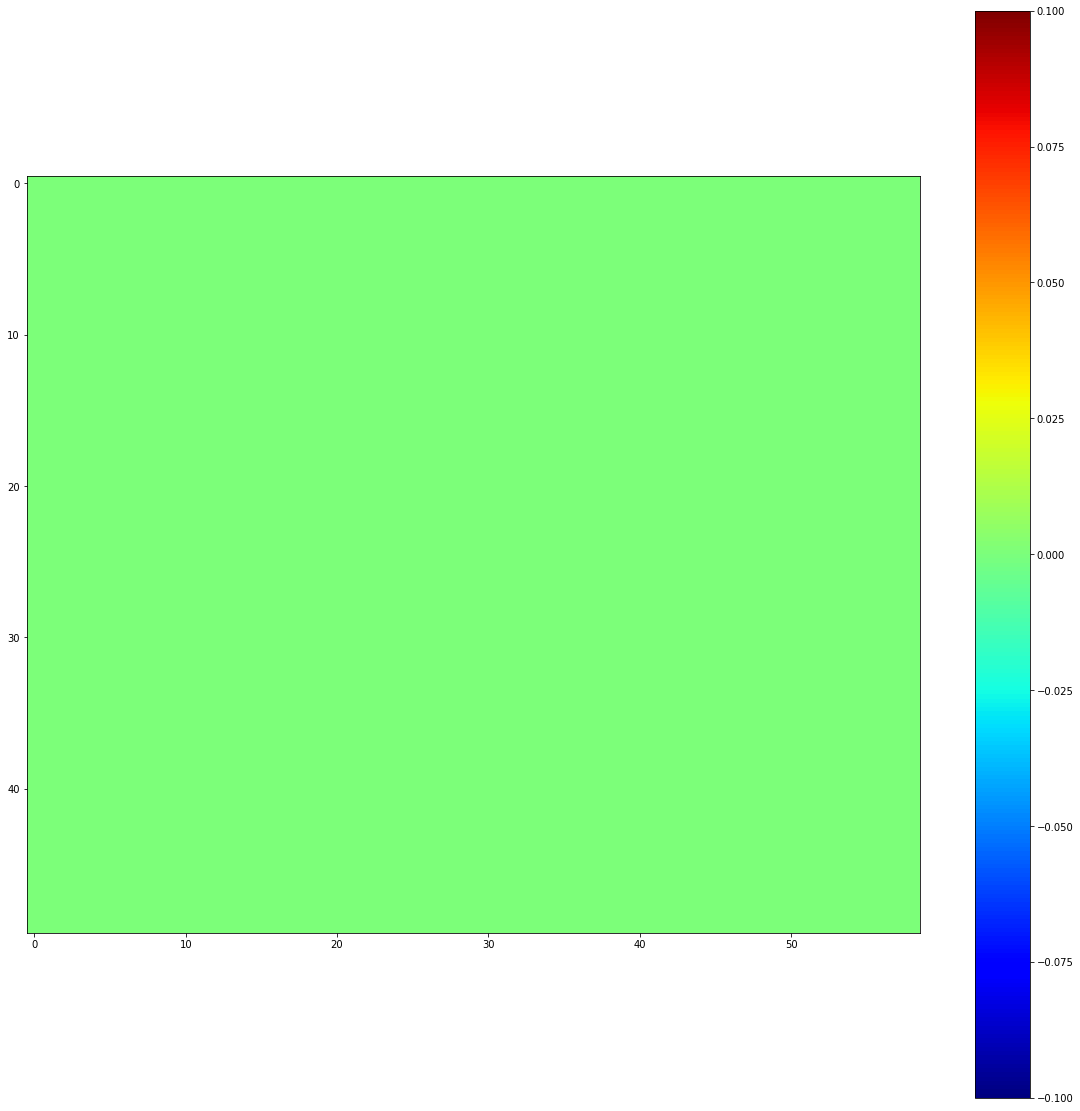

In [7]:
plt.figure(figsize=(20, 20))
m = plt.imshow(np.delete(np.sum(d, axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)